In [ ]:
import pandas as pd
data=pd.read_csv("data/data_with_cdna_codon.csv")
data.head()
# data.columns 


# Data collection

In [ ]:
import pandas as pd
import requests, time
from Bio import SeqIO
from io import StringIO

df=pd.read_csv("data/tpi_sequences_filtered_withcodon.csv")

# --- Fetch cDNA using UniProt JSON API ---
def fetch_cdna(uniprot_id):
    try:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}?format=json"
        r = requests.get(url, timeout=30)
        if r.status_code != 200:
            return None
        data = r.json()

        # Find EMBL/GenBank cross-reference
        genbank_ids = [
            x["id"] for x in data.get("uniProtKBCrossReferences", [])
            if x["database"] == "EMBL"
        ]
        if not genbank_ids:
            return None
        genbank_id = genbank_ids[0]

        # Fetch CDS fasta from NCBI
        gb_url = f"https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi?id={genbank_id}&db=nuccore&report=fasta_cds_na"
        gb_resp = requests.get(gb_url, timeout=30)
        if gb_resp.status_code != 200:
            return None

        handle = StringIO(gb_resp.text)
        record = list(SeqIO.parse(handle, "fasta"))
        if not record:
            return None
        return str(record[0].seq)
    except Exception as e:
        print(f"Error fetching cDNA for {uniprot_id}: {e}")
        return None


# --- Fetch codon usage with retry ---
def fetch_codon_usage(organism):
    org_query = organism.lower().replace(" ", "+")
    url = f"https://www.kazusa.or.jp/codon/cgi-bin/spsearch.cgi?species={org_query}"

    for attempt in range(3):
        try:
            r = requests.get(url, timeout=60)
            if r.ok and "<pre>" in r.text:
                return r.text.split("<pre>")[1].split("</pre>")[0].strip()
        except Exception:
            time.sleep(5)
    return None


# --- Fill dataframe ---
for i, row in df.iterrows():
    if pd.isna(row["CDNA"]):
        cdna = fetch_cdna(row["ID"])
        print(cdna)
        if cdna:
            df.at[i, "CDNA"] = cdna
            # time.sleep(2)

    if pd.isna(row["codon usuage table"]):
        codon_table = fetch_codon_usage(row["Organism"])
        print(codon_table)
        if codon_table:
            df.at[i, "codon usuage table"] = codon_table
            # time.sleep(2)

df.to_csv("data_with_cdna_codon.csv", index=False)
print("✅ Done")


# Draw graphs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data ---
data = pd.read_csv("data/data_with_cdna_codon.csv")               # must contain "cDNA" column
codon_usage = pd.read_csv("data/codontables/codonusugae.csv") # must contain "Codon","Frequency","AA"

# Make codon usage dictionary
usage_dict = dict(zip(codon_usage["Codon"], codon_usage["Frequency"]))
aa_dict    = dict(zip(codon_usage["Codon"], codon_usage["AA"]))

# Define consistent colors per amino acid
aa_colors = {}
palette = plt.cm.tab20.colors   # 20 distinct colors
for i, aa in enumerate(sorted(set(aa_dict.values()))):
    aa_colors[aa] = palette[i % len(palette)]

# --- Step 2: Process each sequence ---
for idx, row in data.iterrows():
    cdna_seq = row["CDNA"].upper().replace("\n", "").replace(" ", "")

    # Break into codons in *order*
    codons = [cdna_seq[i:i+3] for i in range(0, len(cdna_seq), 3) if len(cdna_seq[i:i+3]) == 3]

    # Prepare data table
    records = []
    for codon in codons:
        if codon in usage_dict:
            aa = aa_dict[codon]
            exp = usage_dict[codon]
            records.append({
                "Codon": codon,
                "AminoAcid": aa,
                "Observed": 1,   # each codon appears once in order
                "Expected": exp,
                "RelativeFreq": 1/exp   # since each codon occurs once in the sequence order
            })

    df = pd.DataFrame(records)
    df["Label"] = df["AminoAcid"] + "-" + df["Codon"]

    # --- Step 3: Plot ---
    plt.figure(figsize=(16,6))
    bars = plt.bar(range(len(df)), df["RelativeFreq"], edgecolor="black")

    # Color bars by amino acid family
    for i, aa in enumerate(df["AminoAcid"]):
        bars[i].set_color(aa_colors[aa])

    # Add codon labels along x-axis
    plt.xticks(range(len(df)), df["Label"], rotation=90, fontsize=8)

    # Reference line at 1.0
    plt.axhline(1, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Relative Frequency (Observed / Expected)")
    plt.title(f"Rare Codon Analysis for Sequence {idx+1}")
    plt.tight_layout()
    plt.show()


# create codon usuage table

In [ ]:
new_data = pd.read_csv("data_with_cdna_codon.csv")
new_data

# get structures

In [ ]:
import os
import requests
import pandas as pd

# === Input / Output ===
input_csv = "data/data_with_cdna_codon.csv"       # your input file
output_csv = "proteins_with_structures.csv"
out_dir = "structures"

# Create folder for structures
os.makedirs(out_dir, exist_ok=True)

def fetch_uniprot_id(protein_id):
    """Get UniProt accession using protein ID"""
    url = f"https://rest.uniprot.org/uniprotkb/search?query={protein_id}&format=json&size=1"
    r = requests.get(url)
    if r.status_code == 200 and r.json().get("results"):
        return r.json()["results"][0]["primaryAccession"]
    return None

def fetch_pdb(uniprot_id):
    """Get PDB IDs linked to a UniProt accession"""
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    r = requests.get(url)
    if r.status_code == 200:
        data = r.json()
        db_refs = data.get("uniProtKBCrossReferences", [])
        pdb_ids = [ref["id"] for ref in db_refs if ref["database"] == "PDB"]
        return pdb_ids
    return []

def download_structure(pdb_id, save_path):
    """Download experimental PDB structure"""
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    r = requests.get(url)
    if r.status_code == 200:
        with open(save_path, "w") as f:
            f.write(r.text)
        return True
    return False

def fetch_alphafold(uniprot_id, save_path):
    """Download AlphaFold predicted structure if no PDB"""
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
    r = requests.get(url)
    if r.status_code == 200:
        with open(save_path, "w") as f:
            f.write(r.text)
        return True
    return False

# === Main Processing ===
data = pd.read_csv(input_csv)
structure_files = []

for idx, row in data.iterrows():
    protein_id = row["ID"]
    uniprot_id = fetch_uniprot_id(protein_id)
    structure_file = None

    if uniprot_id:
        pdb_ids = fetch_pdb(uniprot_id)
        if pdb_ids:
            pdb_id = pdb_ids[0]  # take first available
            save_path = os.path.join(out_dir, f"{protein_id}_{pdb_id}.pdb")
            if download_structure(pdb_id, save_path):
                structure_file = save_path
        else:
            # fallback to AlphaFold
            save_path = os.path.join(out_dir, f"{protein_id}_AF.pdb")
            if fetch_alphafold(uniprot_id, save_path):
                structure_file = save_path

    structure_files.append(structure_file)

# Add column to DataFrame
data["Structure_File"] = structure_files

# Save results
data.to_csv(output_csv, index=False)
print(f"✅ Done! Structures saved in '{out_dir}' and updated CSV written to '{output_csv}'")



# torsion angles

In [ ]:
import os
import math
import glob
import warnings
import pandas as pd
from typing import Optional, Tuple, List, Dict

from Bio.PDB import PDBParser, MMCIFParser, PPBuilder
from Bio.PDB.vectors import Vector, calc_dihedral
from Bio.PDB.Residue import Residue
from Bio.PDB.Atom import Atom

# ---------- Config ----------
STRUCT_DIR = "structures"        # your folder with downloaded structures
OUT_CSV   = "torsion_angles_all.csv"
INCLUDE_HETATM = False           # set True if you also want ligands/modified residues

# ---------- Utilities ----------
def deg(rad: Optional[float]) -> Optional[float]:
    return None if rad is None else (rad * 180.0 / math.pi)

def pick_atom(res: Residue, name: str) -> Optional[Atom]:
    """
    Get an atom by name from a residue, preferring altloc ' ' or 'A'.
    Returns None if missing.
    """
    if name not in res:
        return None
    atom = res[name]
    # If multiple altlocs, pick best
    if atom.is_disordered():
        # Prefer blank or 'A'
        for alt in (' ', 'A'):
            if alt in atom.disordered_get_id_list():
                return atom.disordered_select(alt)
        # Otherwise pick the first
        atom.disordered_select(atom.disordered_get_id_list()[0])
    return atom

def atom_vec(res: Residue, name: str) -> Optional[Vector]:
    a = pick_atom(res, name)
    return None if a is None else Vector(a.get_coord())

def res_id_str(chain_id: str, res: Residue) -> str:
    hetflag, seq, icode = res.id
    tag = f"{seq}{icode.strip() or ''}"
    if hetflag.strip() != "":  # HETATM / modified residue labels like 'H_MSE'
        tag = f"{hetflag}:{tag}"
    return f"{chain_id}:{tag}"

# ---------- Backbone torsions ----------
def backbone_phi_psi_omega(prev_res: Optional[Residue],
                           curr_res: Residue,
                           next_res: Optional[Residue]) -> Tuple[Optional[float], Optional[float], Optional[float]]:
    """
    Returns (phi, psi, omega) in radians (or None if not computable).
    Definitions:
      phi(i)   = dihedral C(i-1) - N(i)  - CA(i) - C(i)
      psi(i)   = dihedral N(i)   - CA(i) - C(i)  - N(i+1)
      omega(i) = dihedral CA(i-1)- C(i-1)- N(i)  - CA(i)
    """
    phi = psi = omega = None

    # Curr atoms
    N  = atom_vec(curr_res, "N")
    CA = atom_vec(curr_res, "CA")
    C  = atom_vec(curr_res, "C")

    if prev_res is not None:
        C_prev  = atom_vec(prev_res, "C")
        CA_prev = atom_vec(prev_res, "CA")
        if C_prev is not None and N is not None and CA is not None and C is not None:
            phi = calc_dihedral(C_prev, N, CA, C)
        if CA_prev is not None and C_prev is not None and N is not None and CA is not None:
            omega = calc_dihedral(CA_prev, C_prev, N, CA)

    if next_res is not None:
        N_next = atom_vec(next_res, "N")
        if N is not None and CA is not None and C is not None and N_next is not None:
            psi = calc_dihedral(N, CA, C, N_next)

    return phi, psi, omega

# ---------- Side chain chi definitions ----------
# Dunbrack-like atom definitions for χ angles per residue (chi1..chi4).
# Keys are standard three-letter residue names.
CHI_DEFS: Dict[str, List[List[str]]] = {
    # χ1
    "ARG": [["N","CA","CB","CG"], ["CA","CB","CG","CD"], ["CB","CG","CD","NE"], ["CG","CD","NE","CZ"]],
    "LYS": [["N","CA","CB","CG"], ["CA","CB","CG","CD"], ["CB","CG","CD","CE"], ["CG","CD","CE","NZ"]],
    "GLU": [["N","CA","CB","CG"], ["CA","CB","CG","CD"], ["CB","CG","CD","OE1"]],  # χ3 uses OE1/2; either is fine
    "GLN": [["N","CA","CB","CG"], ["CA","CB","CG","CD"], ["CB","CG","CD","OE1"]],
    "ASP": [["N","CA","CB","CG"], ["CA","CB","CG","OD1"]],
    "ASN": [["N","CA","CB","CG"], ["CA","CB","CG","OD1"]],
    "LEU": [["N","CA","CB","CG"], ["CA","CB","CG","CD1"]],
    "ILE": [["N","CA","CB","CG1"], ["CA","CB","CG1","CD1"]],
    "VAL": [["N","CA","CB","CG1"]],
    "THR": [["N","CA","CB","OG1"]],
    "SER": [["N","CA","CB","OG"]],
    "MET": [["N","CA","CB","CG"], ["CA","CB","CG","SD"], ["CB","CG","SD","CE"]],
    "PHE": [["N","CA","CB","CG"], ["CA","CB","CG","CD1"]],
    "TYR": [["N","CA","CB","CG"], ["CA","CB","CG","CD1"]],
    "TRP": [["N","CA","CB","CG"], ["CA","CB","CG","CD1"]],
    "HIS": [["N","CA","CB","CG"], ["CA","CB","CG","ND1"]],
    "CYS": [["N","CA","CB","SG"]],
    "PRO": [["C","N","CA","CB"], ["N","CA","CB","CG"]],  # special; ring causes unusual definitions
    # One-chi residues below already included (SER, THR, CYS, VAL)
    # No side chains for GLY, ALA beyond CB; Ala has no χ.
}

def compute_chis(res: Residue) -> List[Optional[float]]:
    """
    Compute up to χ1..χ4 (radians) for the given residue if defined.
    Missing atoms => None for that χ and subsequent ones are still attempted where defined.
    """
    chis: List[Optional[float]] = []
    name = res.get_resname().upper()

    if name not in CHI_DEFS:
        return chis  # empty list

    for atom_names in CHI_DEFS[name]:
        atoms = [atom_vec(res, nm) if nm in ("CB","CG","CD","CE","NZ","OE1","OE2","OD1","OD2","ND1","NE","CZ","SD","SG","OG","OG1","CD1","CG1")
                 else atom_vec(res, nm)
                 for nm in atom_names]
        # Some χ definitions use backbone atoms from current residue; for PRO χ1 uses previous C as the first atom ("C").
        # If any atom missing, append None
        if any(v is None for v in atoms):
            chis.append(None)
        else:
            chis.append(calc_dihedral(*atoms))
    return chis

# ---------- Main walker ----------
def process_structure_file(path: str) -> pd.DataFrame:
    """
    Parse a PDB or mmCIF file and return a dataframe of torsion angles for all residues.
    """
    ext = os.path.splitext(path)[1].lower()
    parser = PDBParser(QUIET=True) if ext == ".pdb" else MMCIFParser(QUIET=True)

    # Some PDBs are noisy; suppress PDB warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        structure_id = os.path.basename(path)
        structure = parser.get_structure(structure_id, path)

    rows = []
    for model in structure:
        for chain in model:
            # Optionally skip HETATM/non-standard residues
            residues = [r for r in chain.get_residues()
                        if (INCLUDE_HETATM or r.id[0].strip() == "")
                        and r.has_id("N") and r.has_id("CA") and r.has_id("C")]
            for i, res in enumerate(residues):
                prev_res = residues[i-1] if i > 0 else None
                next_res = residues[i+1] if i+1 < len(residues) else None

                phi, psi, omega = backbone_phi_psi_omega(prev_res, res, next_res)
                chis = compute_chis(res)  # radians, variable length per residue

                row = {
                    "file": os.path.basename(path),
                    "model": model.id,
                    "chain": chain.id,
                    "res_id": res_id_str(chain.id, res),
                    "resname": res.get_resname(),
                    "phi_deg": deg(phi),
                    "psi_deg": deg(psi),
                    "omega_deg": deg(omega),
                }
                # Normalize χ columns up to χ4
                for k in range(4):
                    row[f"chi{k+1}_deg"] = deg(chis[k]) if k < len(chis) else None

                rows.append(row)

    return pd.DataFrame(rows)

def main():
    files = sorted(glob.glob(os.path.join(STRUCT_DIR, "*.pdb")) +
                   glob.glob(os.path.join(STRUCT_DIR, "*.cif")))
    if not files:
        print(f"No PDB/mmCIF files found in '{STRUCT_DIR}'.")
        return

    all_dfs = []
    for f in files:
        try:
            df = process_structure_file(f)
            all_dfs.append(df)
            print(f"Processed {os.path.basename(f)}: {len(df)} residues")
        except Exception as e:
            print(f"ERROR processing {f}: {e}")

    if all_dfs:
        out = pd.concat(all_dfs, ignore_index=True)
        out.to_csv(OUT_CSV, index=False)
        print(f"\n✅ Saved torsion angles for {len(out)} residues to '{OUT_CSV}'")
    else:
        print("No residues processed.")

if __name__ == "__main__":
    main()


# cDNA to torsion angles

In [ ]:
import os
import math
import warnings
import pandas as pd
from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.PDB import PDBParser, MMCIFParser
from Bio.PDB.vectors import Vector, calc_dihedral
from Bio.Data import IUPACData

# ---------- CONFIG ----------
INPUT_CSV = "proteins_with_structures.csv"
OUT_CSV   = "codon_torsions_aligned.csv"

# ---------- Helpers ----------
def deg(rad):
    return None if rad is None else rad * 180.0 / math.pi

def split_codons(seq: str):
    seq = seq.strip().upper().replace(" ", "").replace("\n", "")
    return [seq[i:i+3] for i in range(0, len(seq) - len(seq)%3, 3)]

def translate_codons(codons):
    dna_seq = Seq("".join(codons))
    return str(dna_seq.translate(to_stop=False))

# Map three-letter to one-letter amino acids
three_to_one = IUPACData.protein_letters_3to1

def resname_to_aa(resname):
    resname = resname.capitalize()
    return three_to_one.get(resname, "X")  # 'X' for unknown

# ---------- Structure torsion calc ----------
def atom_vec(res, name):
    if not res.has_id(name):
        return None
    atom = res[name]
    return Vector(atom.get_coord())

def backbone_angles(prev_res, res, next_res):
    N, CA, C = atom_vec(res,"N"), atom_vec(res,"CA"), atom_vec(res,"C")
    phi = psi = omega = None
    if prev_res and prev_res.has_id("C") and N and CA and C:
        phi = calc_dihedral(Vector(prev_res["C"].coord), N, CA, C)
        omega = calc_dihedral(Vector(prev_res["CA"].coord), Vector(prev_res["C"].coord), N, CA)
    if next_res and next_res.has_id("N") and N and CA and C:
        psi = calc_dihedral(N, CA, C, Vector(next_res["N"].coord))
    return deg(phi), deg(psi), deg(omega)

def parse_structure(structure_file):
    if not os.path.exists(structure_file):
        return None
    ext = os.path.splitext(structure_file)[1].lower()
    parser = PDBParser(QUIET=True) if ext == ".pdb" else MMCIFParser(QUIET=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        struct = parser.get_structure("S", structure_file)
    model = list(struct)[0]
    chain = list(model)[0]
    residues = [r for r in chain.get_residues() if r.id[0] == " "]
    data = []
    for i, res in enumerate(residues):
        prev_res = residues[i-1] if i > 0 else None
        next_res = residues[i+1] if i < len(residues)-1 else None
        phi, psi, omega = backbone_angles(prev_res, res, next_res)
        data.append((resname_to_aa(res.get_resname()), res.id[1], phi, psi, omega))
    return data

# ---------- Sequence alignment ----------
def align_sequences(seq1, seq2):
    """Align two sequences and return aligned versions."""
    aln = pairwise2.align.globalms(seq1, seq2, 2, -1, -0.5, -0.1, one_alignment_only=True)[0]
    return aln.seqA, aln.seqB

# ---------- Main ----------
def main():
    df = pd.read_csv(INPUT_CSV, sep=",")
    all_rows = []
    df.columns = df.columns.str.strip()

    for _, row in df.iterrows():
        if pd.isna(row["CDNA"]) or pd.isna(row["Structure_File"]):
            continue

        codons = split_codons(row["CDNA"])
        aa_from_cDNA = translate_codons(codons)
        torsions = parse_structure(row["Structure_File"])
        if torsions is None:
            continue

        # Extract structure amino acids
        aa_from_struct = "".join([t[0] for t in torsions])

        # Align sequences
        aln_cDNA, aln_struct = align_sequences(aa_from_cDNA, aa_from_struct)

        codon_idx = 0
        struct_idx = 0
        for i in range(len(aln_cDNA)):
            aa_c = aln_cDNA[i]
            aa_s = aln_struct[i]

            if aa_c == "-":
                # gap in cDNA, skip
                struct_idx += 1
                continue
            if aa_s == "-":
                # gap in structure, skip
                codon_idx += 1
                continue

            # Map codon to structure residue
            codon = codons[codon_idx]
            resname, resnum, phi, psi, omega = torsions[struct_idx]
            all_rows.append({
                "ID": row["ID"],
                "Organism": row["Organism"],
                "Codon_Index": codon_idx + 1,
                "Codon": codon,
                "AA_from_cDNA": aa_c,
                "AA_from_structure": aa_s,
                "Residue_Number": resnum,
                "Phi": phi,
                "Psi": psi,
                "Omega": omega,
            })
            codon_idx += 1
            struct_idx += 1

    out = pd.DataFrame(all_rows)
    out.to_csv(OUT_CSV, index=False)
    print(f"✅ Saved {len(out)} codon-torsion rows to {OUT_CSV}")

if __name__ == "__main__":
    main()


In [ ]:
data2 = pd.read_csv("codon_torsions.csv")
data2.head()


# codon usuage

In [ ]:
import os
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Load your data
df = pd.read_csv("codon_torsions.csv")

import os
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

def get_codon_usage_from_unr(organism_name, proteins="Nuclear",out_dir="codon_tables"):
    # Build URL
    search_name = organism_name.replace(" ", "+")
    url = f"http://codonstatsdb.unr.edu/cgi-bin/submit.pl?species={search_name}&proteins={proteins}"
    
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Failed to fetch data for {organism_name}")
        return None
    
    soup = BeautifulSoup(r.text, "html.parser")
    
    # Find the script block with data.addRows
    script_text = None
    for script in soup.find_all("script"):
        if "data.addRows" in script.text:
            script_text = script.text
            break
    
    if not script_text:
        print(f"No codon data found for {organism_name}")
        return None

    # Extract the array inside addRows([...])
    match = re.search(r"data\.addRows\(\[(.*)\]\);", script_text, re.S)
    if not match:
        print("Could not parse data.addRows block")
        return None
    
    rows_text = match.group(1)

    # Split into individual rows
    row_pattern = re.compile(r"\['([^']+)','([^']+)','([^']+)','([^']+)','([^']+)'\]")
    rows = row_pattern.findall(rows_text)

    # Create DataFrame
    df = pd.DataFrame(rows, columns=["AminoAcid", "Codon", "Count", "RelativeAdaptiveness", "Preference"])
    df["Count"] = df["Count"].astype(int)
    df["RelativeAdaptiveness"] = df["RelativeAdaptiveness"].astype(float)

    # Ensure the folder exists
    os.makedirs(out_dir, exist_ok=True)
    
    # Save DataFrame as CSV
    filename = os.path.join("codon_tables", f"{organism_name.replace(' ', '_')}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved codon usage table to {filename}")
    
    return df




def parse_codon_usage(pre_block, organism, out_dir="old_codon_tables"):
    
    """
    Parse codon usage data into a DataFrame and save as CSV.
    
    Args:
        pre_block (str): String containing codon usage data
        organism (str): Name of the organism
        out_dir (str): Output directory for CSV file (default: 'codon_tables')
    
    Returns:
        pandas.DataFrame: DataFrame containing parsed codon usage data
    """
    pre_block = pre_block.replace('U', 'T')
    # Initialize lists to store data
    codons = []
    amino_acids = []
    frequencies = []
    
    # Split input string into lines
    lines = pre_block.strip().split('\n')
    
    
    # Regular expression to match codon, AA, and frequency
    pattern = r'(\w{3})\s+(\w|\*)\s+(\d+\.\d+)'
    
    for line in lines:
        matches = re.findall(pattern, line)
        for match in matches:
            codon, aa, freq = match
            codons.append(codon)
            amino_acids.append(aa)
            frequencies.append(float(freq))
    
    # Create DataFrame
    df = pd.DataFrame({
        'Codon': codons,
        'AA': amino_acids,
        'Frequency': frequencies
    })
    
    # Create output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)
    
    # Save to CSV
    output_file = os.path.join(out_dir, f"{organism}.csv")
    df.to_csv(output_file, index=False)
    
    return df


def get_codon_usage_from_kazusa(organism_name):
    search_name = organism_name.replace(" ", "+")
    search_url = f"https://www.kazusa.or.jp/codon/cgi-bin/spsearch.cgi?species={search_name}&c=s"
    
    # Step 1: Search page
    r = requests.get(search_url)
    soup = BeautifulSoup(r.text, "html.parser")
 
    # Step 2: Find top organism link
    top_link = soup.find("a", href=True)
    if not top_link:
        print(f"No link found for {organism_name}")
        return None
    
    table_url = "https://www.kazusa.or.jp" + top_link['href']+'&aa=1&style=N'
    
    # Step 3: Fetch codon usage table
    r2 = requests.get(table_url)
    soup2 = BeautifulSoup(r2.text, "html.parser")
    
    pre_tags = soup2.find_all("pre")
    if not pre_tags:
        print(f"No codon data found for {organism_name}")
        return None
    
    # take first <pre> block
    pre_text = pre_tags[0].get_text()
    
    return parse_codon_usage(pre_text, organism=organism_name)

# Add a new column for relative frequency
df["Relative_Freq"] = None

codon_usage_cache = {}

for i, row in df.iterrows():
    codon = row["Codon"].upper()
    organism = row["Organism"]
    
    if organism not in codon_usage_cache:
        codon_usage_cache[organism] = get_codon_usage_from_kazusa(organism)
        # codon_usage_cache[organism] = get_codon_usage_from_unr(organism, proteins="Nuclear",out_dir="codon_tables")

    
    # usage_table = codon_usage_cache.get(organism)
    # if usage_table and codon in usage_table:
    #     df.at[i, "Relative_Freq"] = usage_table[codon]

# Save the updated data
df.to_csv("data_with_codon_freq.csv", index=False)
print(df.head())


# with relative frequency

In [ ]:
import os
import pandas as pd

input_dir = "old_codon_tables"   # folder containing your CSVs
output_dir = "codon_tables_with_relative"  # folder to save updated files
os.makedirs(output_dir, exist_ok=True)

def add_relative_frequency(df):
    """
    Adds a Relative_Freq column to a codon usage DataFrame.
    Relative_Freq = Frequency / max(Frequency) for the synonymous codons of the same amino acid.
    """
    df["Relative_Freq"] = df.groupby("AA")["Frequency"].transform(lambda x: x / x.max())
    return df

# Loop through all CSV files in the folder
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)
        
        df = add_relative_frequency(df)
        
        output_path = os.path.join(output_dir, filename)
        df.to_csv(output_path, index=False)
        print(f"Processed {filename} -> saved to {output_path}")


In [ ]:
data3 = pd.read_csv("/home/masavir10728587/Desktop/1.Work/codon/codon_tables/Achlya bisexualis.csv")
data3.head()

# codon merge with torsion etc

In [ ]:
import pandas as pd
import os

def add_Relative_Frequency(original_csv_path, codon_usage_folder, output_csv_path):
    # Read the original dataset
    original_df = pd.read_csv(original_csv_path)
    
    # Initialize a list to store updated rows
    updated_rows = []

    # Process each unique organism separately
    for organism in original_df['Organism'].unique():
        # Construct path to codon usage table for this organism
        codon_usage_path = os.path.join(codon_usage_folder, f"{organism}.csv")
        # codon_usage_path = os.path.join(codon_usage_folder, f"{organism.replace(' ', '_')}.csv")
        
        # Check if codon usage table exists
        if not os.path.exists(codon_usage_path):
            print("skipping")
            # return
            raise FileNotFoundError(f"Codon usage table for {organism} not found at {codon_usage_path}")
        
        # Read the codon usage table
        codon_usage_df = pd.read_csv(codon_usage_path)
        
        # Create a dictionary mapping codons to their relative adaptiveness
        # codon_freq_dict = dict(zip(codon_usage_df['Codon'], codon_usage_df['RelativeAdaptiveness']))
        codon_freq_dict = dict(zip(codon_usage_df['Codon'], codon_usage_df['Frequency']))
        codon_rel_freq_dict = dict(zip(codon_usage_df['Codon'], codon_usage_df['Relative_Freq']))
        
        # Filter rows for this organism
        org_df = original_df[original_df['Organism'] == organism].copy()
        
        # Map codons to their frequency
        org_df['Relative_Frequency'] = org_df['Codon'].map(codon_freq_dict)
        org_df['Relative_Frequency'] = org_df['Codon'].map(codon_rel_freq_dict)
        
        
        # Append updated rows
        updated_rows.append(org_df)
    
    # Concatenate all updated rows
    updated_df = pd.concat(updated_rows, ignore_index=True)
    
    # Save the updated dataframe to a new CSV file
    updated_df.to_csv(output_csv_path, index=False)
    
    return updated_df

# Example usage
if __name__ == "__main__":
    original_csv = "codon_torsions_aligned.csv"  # Path to your original dataset
    codon_folder = "codon_tables_with_relative"  # Folder containing codon usage tables
    output_csv = "new_codon_torsions_freq.csv"  # Output file path
    
    updated_df = add_Relative_Frequency(original_csv, codon_folder, output_csv)
    print("Updated dataset:")
    print(updated_df.head())


In [11]:
data3 = pd.read_csv("new_codon_torsions_freq.csv")
data3.tail(500)

,ID,Organism,Codon_Index,Codon,AA_from_cDNA,AA_from_structure,Residue_Number,Phi,Psi,Omega,Codon_Frequency,Relative_Frequency
6184,TPIS_CANAL,Candida albicans,232,GGT,G,G,232,-79.353750,-112.012261,171.946929,0.72000,1.000000
6185,TPIS_CANAL,Candida albicans,233,GGT,G,G,233,-60.061091,-27.090690,-169.807030,0.72000,1.000000
6186,TPIS_CANAL,Candida albicans,234,GCT,A,A,234,-71.457232,-18.985290,175.602121,0.58000,1.000000
6187,TPIS_CANAL,Candida albicans,235,TCA,S,S,235,-68.693511,-16.157274,174.155058,0.32000,0.744186
6188,TPIS_CANAL,Candida albicans,236,TTA,L,L,236,-87.706521,1.797082,177.280412,0.74117,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6679,Q9U2R2,Caenorhabditis elegans,243,ATC,I,I,243,-64.239421,-44.787731,178.959367,0.06000,0.093750
6680,Q9U2R2,Caenorhabditis elegans,244,AAC,N,N,244,-60.872477,-38.993566,179.886787,0.09000,0.098901
6681,Q9U2R2,Caenorhabditis elegans,245,GCC,A,A,245,-63.182224,-32.236068,-179.844185,0.08000,0.153846
6682,Q9U2R2,Caenorhabditis elegans,246,AGA,R,R,246,-82.641264,-33.918617,-179.196996,0.67000,1.000000


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ----------------- CONFIG -----------------
INPUT_CSV = "new_codon_torsions_freq.csv"       # path to your CSV
OUTPUT_DIR = "codon_plots"       # folder to save plots
RARE_THRESHOLD = 0.2             # codons below this relative frequency are considered rare

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------- LOAD DATA -----------------
df = pd.read_csv(INPUT_CSV)

# ----------------- PLOT PER PROTEIN -----------------
for protein_id, protein_df in df.groupby("ID"):
    plt.figure(figsize=(15, 4))
    
    # Colors: red for rare, blue for common
    colors = protein_df["Relative_Frequency"].apply(lambda x: 'red' if x < RARE_THRESHOLD else 'blue')
    # print(colors)
    
    # Plot codon relative frequencies
    plt.bar(protein_df["Codon_Index"], protein_df["Relative_Frequency"], color=colors)
    
    # Labels and title
    plt.xlabel("Codon Index")
    plt.ylabel("Relative Frequency")
    plt.title(f"Codon Usage for Protein {protein_id}")
    
    # Optional: add codon letters on top of bars
    for idx, row in protein_df.iterrows():
        plt.text(row["Codon_Index"], row["Relative_Frequency"] + 0.02, row["Codon"], 
                 ha='center', va='bottom', fontsize=8, rotation=90)
    
    plt.ylim(0, 1.1)  # keep relative frequency in view
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(OUTPUT_DIR, f"{protein_id}_codon_usage.png"))
    plt.close()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


# save partial structures

In [3]:
import pandas as pd
import os
from Bio.PDB import PDBParser, PDBIO, Select

# ----------------- CONFIG -----------------
INPUT_CSV = "new_codon_torsions_freq.csv"   # path to your CSV
STRUCTURE_DIR = "structures"                # folder containing original structures
OUTPUT_DIR = "rare_structures"              # folder to save partial structures
RARE_THRESHOLD = 0.2                        # codons below this relative frequency are considered rare

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------- LOAD DATA -----------------
df = pd.read_csv(INPUT_CSV)

# ----------------- DEFINE SELECT CLASS -----------------
class RareCodonSelect(Select):
    def __init__(self, rare_residues):
        self.rare_residues = rare_residues
    def accept_residue(self, residue):
        # residue id is a tuple: (hetero_flag, resseq, icode)
        return residue.get_id()[1] in self.rare_residues

# ----------------- PROCESS EACH PROTEIN -----------------
parser = PDBParser(QUIET=True)
io = PDBIO()

for protein_id, protein_df in df.groupby("ID"):
    # Get indices of rare codons
    rare_residues = protein_df.loc[protein_df["Relative_Frequency"] < RARE_THRESHOLD, "Residue_Number"].tolist()
    
    if not rare_residues:
        continue  # skip if no rare codons
    
    # Find matching PDB file
    pdb_file = None
    for f in os.listdir(STRUCTURE_DIR):
        if f.startswith(protein_id):
            pdb_file = os.path.join(STRUCTURE_DIR, f)
            break
    
    if not pdb_file:
        print(f"Structure not found for {protein_id}, skipping...")
        continue
    
    # Load structure
    structure = parser.get_structure(protein_id, pdb_file)
    
    # Save only rare residues
    io.set_structure(structure)
    output_path = os.path.join(OUTPUT_DIR, f"{protein_id}_rare.pdb")
    io.save(output_path, RareCodonSelect(rare_residues))
    
    print(f"Saved rare codon structure for {protein_id} -> {output_path}")


Saved rare codon structure for O77458 -> rare_structures/O77458_rare.pdb
Saved rare codon structure for Q9FS79 -> rare_structures/Q9FS79_rare.pdb
Saved rare codon structure for Q9GTX8 -> rare_structures/Q9GTX8_rare.pdb
Saved rare codon structure for Q9HGY8 -> rare_structures/Q9HGY8_rare.pdb
Saved rare codon structure for Q9M7R8 -> rare_structures/Q9M7R8_rare.pdb
Saved rare codon structure for Q9U2R2 -> rare_structures/Q9U2R2_rare.pdb
Saved rare codon structure for TPIS_CANAL -> rare_structures/TPIS_CANAL_rare.pdb
Saved rare codon structure for TPIS_CHICK -> rare_structures/TPIS_CHICK_rare.pdb
Saved rare codon structure for TPIS_COPJA -> rare_structures/TPIS_COPJA_rare.pdb
Saved rare codon structure for TPIS_CULTA -> rare_structures/TPIS_CULTA_rare.pdb
Saved rare codon structure for TPIS_DROME -> rare_structures/TPIS_DROME_rare.pdb
Saved rare codon structure for TPIS_EMENI -> rare_structures/TPIS_EMENI_rare.pdb
Saved rare codon structure for TPIS_HORVU -> rare_structures/TPIS_HORVU_rare



👉 **Does codon usage (and its frequency bias) influence local protein structure, specifically torsion angles (ϕ, ψ, ω) at the residue level?**

Let’s break it down step by step:

---

## 1. **Biological Background**

* **Codon frequency (codon bias):** Organisms prefer certain codons more often than others for the same amino acid. This is influenced by tRNA abundance, translation efficiency, and gene regulation.
* **Torsion angles (ϕ, ψ, ω):** Describe the backbone conformation of residues, which ultimately defines secondary structure (α-helix, β-sheet, loops, etc.).
* **Hypothesized link:**

  * Rare codons may **slow translation**, causing ribosomes to pause. This can provide time for local co-translational folding, which might influence torsion angles.
  * Frequent codons may correlate with **smooth translation**, reducing pauses, and possibly altering how residues adopt conformations.
  * Codon choice might not change the final amino acid sequence, but it can **bias folding pathways**, thus potentially affecting local backbone geometry.

---

## 2. **Possible Hypotheses**

Here are some testable hypotheses you could formulate:

### **H1: Codon frequency is correlated with torsion angle distributions.**

* Rare codons are associated with more variable ϕ/ψ/ω values (greater flexibility).
* Frequent codons are associated with torsion angles close to canonical secondary structures (α-helix: φ≈−60°, ψ≈−45°; β-sheet: φ≈−120°, ψ≈120°).

### **H2: Rare codons occur more often at conformationally strained residues.**

* Residues with unusual torsion angles (outside Ramachandran “allowed” regions) may show enrichment of low-frequency codons, possibly to slow translation for folding assistance.

### **H3: Codon usage bias influences local secondary structure.**

* Frequent codons → stabilized helices/sheets.
* Rare codons → found near loops, turns, or disorder-prone regions.

---

## 3. **Statistical Tests You Can Run**

You already have codon frequency + torsion angles → so we can test these:

1. **Correlation Analysis**

   * Compute Pearson/Spearman correlation between **Codon\_Frequency** and each torsion angle (ϕ, ψ, ω).
   * Expect weak but potentially significant trends.

2. **Group Comparison**

   * Define codons as **High-frequency vs Low-frequency** (e.g., split at median or quantile).
   * Compare torsion angle distributions between the two groups using:

     * Mann–Whitney U test
     * t-test (if normality holds)
     * Circular statistics (since angles wrap around).

3. **Ramachandran Region Enrichment**

   * Classify torsion angles into **secondary structure regions** (helix, sheet, turn).
   * Test whether rare codons are overrepresented in certain regions using χ² test.

4. **Regression Models**

   * Fit a linear/circular regression: `torsion_angle ~ Relative_Frequency + amino_acid + residue_position`.
   * This helps control for amino acid identity (since angle preferences are residue-dependent).

---

## 4. **Formulated Hypothesis Statement**

Here’s a refined hypothesis you could use in your study:

> **Hypothesis:** Codon usage bias, as reflected in codon frequency, has a measurable relationship with local protein backbone torsion angles. Specifically, residues encoded by rare codons will show greater deviation from canonical torsion angle distributions and be enriched in flexible regions (loops/turns), whereas residues encoded by frequent codons will align more closely with stable secondary structure conformations.

---

👉 Do you want me to **write the actual statistical analysis code (Python/Pandas/Scipy/Statsmodels)** for testing these hypotheses on your dataset?


In [ ]:
"""
codon_torsion_stats.py

Run a suite of statistical tests to investigate relationships between codon frequency
and backbone torsion angles (phi, psi, omega).

Dependencies:
    pip install pandas numpy scipy statsmodels

Usage:
    python codon_torsion_stats.py /path/to/your_data.csv

Outputs:
    - results_summary.csv       (summary of major tests)
    - detailed_results.json     (detailed numeric outputs)
    - region_counts.csv         (counts for contingency tables)
"""

import sys
import os
import json
import warnings
from collections import OrderedDict

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------
# Helper functions
# -------------------------

def load_data(path):
    df = pd.read_csv(path, sep=None, engine='python')  # auto-detect delimiter
    df = df[:250]
    print(df)
    return df

def clean_and_prepare(df):
    # Ensure necessary columns exist
    for c in ['Relative_Frequency', 'Phi', 'Psi', 'Omega', 'AA_from_cDNA', 'Residue_Number', 'Codon']:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    # Drop rows where Relative_Frequency or AA or Residue_Number are missing
    df = df.dropna(subset=['Relative_Frequency', 'AA_from_cDNA', 'Residue_Number'])

    # Convert numeric columns
    df['Relative_Frequency'] = pd.to_numeric(df['Relative_Frequency'], errors='coerce')
    df['Phi'] = pd.to_numeric(df['Phi'], errors='coerce')
    df['Psi'] = pd.to_numeric(df['Psi'], errors='coerce')
    df['Omega'] = pd.to_numeric(df['Omega'], errors='coerce')
    df['Residue_Number'] = pd.to_numeric(df['Residue_Number'], errors='coerce')

    # Normalize angles into [-180, 180]
    for angle in ['Phi', 'Psi', 'Omega']:
        df[angle] = df[angle].apply(lambda x: normalize_angle(x) if not pd.isna(x) else np.nan)

    # Add sine and cosine transforms for circular handling (angles in radians)
    for angle in ['Phi', 'Psi', 'Omega']:
        rad = np.deg2rad(df[angle])
        df[f'{angle}_sin'] = np.sin(rad)
        df[f'{angle}_cos'] = np.cos(rad)

    # Create codon-frequency groups (low/medium/high) - quartiles by default
    df['codon_freq_quantile'] = pd.qcut(df['Relative_Frequency'].rank(method='first'), q=4, labels=['Q1','Q2','Q3','Q4'])

    # binary high/low by median
    median = df['Relative_Frequency'].median()
    df['codon_high'] = (df['Relative_Frequency'] >= median).astype(int)

    # Ensure amino acid is categorical
    df['AA'] = df['AA_from_cDNA'].astype(str).str.upper()

    return df

def normalize_angle(angle):
    """Normalize to [-180, 180). Works for degrees. NaNs preserved."""
    if pd.isna(angle):
        return np.nan
    a = ((angle + 180) % 360) - 180
    # convert -180 to 180 if appears
    if a == -180:
        a = 180
    return a

def circular_mean_deg(angles_deg):
    angles = np.deg2rad(angles_deg[~np.isnan(angles_deg)])
    if angles.size == 0:
        return np.nan
    mean_angle = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))
    return np.rad2deg(mean_angle)

def resultant_length_deg(angles_deg):
    angles = np.deg2rad(angles_deg[~np.isnan(angles_deg)])
    if angles.size == 0:
        return np.nan
    R = np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2)
    return R

# -------------------------
# Statistical Tests
# -------------------------

def correlation_tests(df, angle_col='Phi'):
    results = {}
    x = df['Relative_Frequency'].values
    y = df[angle_col].values

    valid = ~np.isnan(x) & ~np.isnan(y)

    # Pearson & Spearman on raw degrees (note: may be problematic because of angle wrap)
    if valid.sum() >= 3:
        pearson_r, pearson_p = stats.pearsonr(x[valid], y[valid])
        spearman_r, spearman_p = stats.spearmanr(x[valid], y[valid])
    else:
        pearson_r = pearson_p = spearman_r = spearman_p = np.nan

    results['pearson'] = {'r': float(pearson_r) if not pd.isna(pearson_r) else np.nan,
                          'p': float(pearson_p) if not pd.isna(pearson_p) else np.nan,
                          'n': int(valid.sum())}

    results['spearman'] = {'rho': float(spearman_r) if not pd.isna(spearman_r) else np.nan,
                           'p': float(spearman_p) if not pd.isna(spearman_p) else np.nan,
                           'n': int(valid.sum())}

    # Circular-aware: correlate codon frequency with sin and cos of the angle separately
    sin_col = df[f'{angle_col}_sin'].values
    cos_col = df[f'{angle_col}_cos'].values
    valid_sc = ~np.isnan(x) & ~np.isnan(sin_col) & ~np.isnan(cos_col)

    if valid_sc.sum() >= 3:
        r_sin, p_sin = stats.pearsonr(x[valid_sc], sin_col[valid_sc])
        r_cos, p_cos = stats.pearsonr(x[valid_sc], cos_col[valid_sc])
    else:
        r_sin = p_sin = r_cos = p_cos = np.nan

    results['circular'] = {
        'pearson_sin': {'r': float(r_sin) if not pd.isna(r_sin) else np.nan, 'p': float(p_sin) if not pd.isna(p_sin) else np.nan},
        'pearson_cos': {'r': float(r_cos) if not pd.isna(r_cos) else np.nan, 'p': float(p_cos) if not pd.isna(p_cos) else np.nan},
    }

    # Also compute circular-linear correlation approximation: combine sin & cos effects into effect size
    if not pd.isna(r_sin) and not pd.isna(r_cos):
        combined_strength = np.sqrt(r_sin**2 + r_cos**2)  # rough effect magnitude
    else:
        combined_strength = np.nan

    results['circular']['combined_strength'] = float(combined_strength) if not pd.isna(combined_strength) else np.nan

    return results

def group_comparisons(df, angle_col='Phi', split_by='codon_high'):
    # split into groups
    res = {}
    df_sub = df[[angle_col, split_by]].dropna()
    if df_sub.shape[0] < 3:
        return {"error": "Not enough data"}

    group0 = df_sub.loc[df_sub[split_by] == 0, angle_col].dropna().values
    group1 = df_sub.loc[df_sub[split_by] == 1, angle_col].dropna().values

    # t-test (assumes angles approx normal - questionable)
    try:
        t_stat, t_p = stats.ttest_ind(group0, group1, nan_policy='omit', equal_var=False)
    except Exception:
        t_stat = t_p = np.nan

    # Mann–Whitney U
    try:
        u_stat, u_p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
    except Exception:
        u_stat = u_p = np.nan

    # For circular check: compare resultant vector lengths
    reslen0 = resultant_length_deg(group0)
    reslen1 = resultant_length_deg(group1)

    res['t_test'] = {'t': float(t_stat) if not pd.isna(t_stat) else np.nan, 'p': float(t_p) if not pd.isna(t_p) else np.nan,
                     'n0': int(len(group0)), 'n1': int(len(group1))}
    res['mannwhitney'] = {'u': float(u_stat) if not pd.isna(u_stat) else np.nan, 'p': float(u_p) if not pd.isna(u_p) else np.nan}
    res['resultant_length'] = {'group0_R': float(reslen0) if not pd.isna(reslen0) else np.nan,
                               'group1_R': float(reslen1) if not pd.isna(reslen1) else np.nan}
    return res

# -------------------------
# Ramachandran region classification
# -------------------------

def classify_ramachandran(df):
    """
    Heuristic classification into: helix, sheet, left_helical, other
    Ranges are approximate and can be tuned.
    """
    def classify(phi, psi):
        if np.isnan(phi) or np.isnan(psi):
            return np.nan
        # alpha helix region: phi ~ -60 ± 40 ; psi ~ -40 ± 60
        if (-100 <= phi <= -20) and (-100 <= psi <= 20):
            return 'alpha_helix'
        # beta sheet: phi ~ -150 to -60 ; psi ~ 90 to 180
        if (-180 <= phi <= -60) and (60 <= psi <= 180):
            return 'beta_sheet'
        # left-handed helix (small region)
        if (40 <= phi <= 100) and (-30 <= psi <= 80):
            return 'left_helix'
        # polypeptide turn-like (broad)
        if (-120 <= phi <= 60) and (-120 <= psi <= 60):
            return 'turn_or_loop'
        return 'other'

    df = df.copy()
    df['rama_region'] = df.apply(lambda r: classify(r['Phi'], r['Psi']), axis=1)
    return df

# -------------------------
# Contingency / enrichment tests
# -------------------------

def rama_enrichment_test(df, angle_region_col='rama_region', freq_group_col='codon_freq_quantile'):
    # Build contingency table: region x freq_quantile
    table = pd.crosstab(df[angle_region_col], df[freq_group_col])
    # Only keep rows/cols with >0
    table = table.loc[(table.sum(axis=1) > 0), (table.sum(axis=0) > 0)]
    if table.size == 0 or table.values.sum() < 5:
        chi2 = p = np.nan
    else:
        chi2, p, dof, expected = stats.chi2_contingency(table)
    return {'contingency_table': table, 'chi2': float(chi2) if not pd.isna(chi2) else np.nan, 'p': float(p) if not pd.isna(p) else np.nan, 'dof': int(dof) if not pd.isna(chi2) else np.nan}

# -------------------------
# Regression models
# -------------------------

def linear_regression_angle(df, angle_col='Phi'):
    """
    OLS regression: angle ~ Relative_Frequency + C(AA) + Residue_Number
    Note: angle is linear in degrees; circularity is not fully handled here.
    """
    df_sub = df[[angle_col, 'Relative_Frequency', 'AA', 'Residue_Number']].dropna()
    if df_sub.shape[0] < 5:
        return {'error': 'Not enough data for regression'}

    # We'll center Residue_Number and Relative_Frequency
    df_sub = df_sub.copy()
    df_sub['Residue_Number_c'] = df_sub['Residue_Number'] - df_sub['Residue_Number'].mean()
    df_sub['Codon_Freq_c'] = df_sub['Relative_Frequency'] - df_sub['Relative_Frequency'].mean()

    formula = f"{angle_col} ~ Codon_Freq_c + Residue_Number_c + C(AA)"
    model = smf.ols(formula, data=df_sub).fit()
    return model

def circular_regression_sin_cos(df, angle_col='Phi'):
    """
    Circular-aware approach: regress sine and cosine components separately:
        sin(angle) ~ Relative_Frequency + C(AA) + Residue_Number
        cos(angle) ~ Relative_Frequency + C(AA) + Residue_Number

    Then combine effect for Relative_Frequency as vector (beta_sin, beta_cos).
    """
    df_sub = df[[f'{angle_col}_sin', f'{angle_col}_cos', 'Relative_Frequency', 'AA', 'Residue_Number']].dropna()
    if df_sub.shape[0] < 10:
        return {'error': 'Not enough data for circular regression'}

    df_sub = df_sub.copy()
    df_sub['Residue_Number_c'] = df_sub['Residue_Number'] - df_sub['Residue_Number'].mean()
    df_sub['Codon_Freq_c'] = df_sub['Relative_Frequency'] - df_sub['Relative_Frequency'].mean()

    # Fit models
    formula = "sin_target ~ Codon_Freq_c + Residue_Number_c + C(AA)"
    df_sub = df_sub.rename(columns={f'{angle_col}_sin': 'sin_target', f'{angle_col}_cos': 'cos_target'})
    m_sin = smf.ols(formula, data=df_sub).fit()

    formula2 = "cos_target ~ Codon_Freq_c + Residue_Number_c + C(AA)"
    m_cos = smf.ols(formula2, data=df_sub).fit()

    # Extract coefficient for Codon_Freq_c
    try:
        beta_sin = m_sin.params['Codon_Freq_c']
        beta_cos = m_cos.params['Codon_Freq_c']
        p_sin = m_sin.pvalues['Codon_Freq_c']
        p_cos = m_cos.pvalues['Codon_Freq_c']
    except Exception:
        beta_sin = beta_cos = p_sin = p_cos = np.nan

    combined_mag = np.sqrt((beta_sin if not pd.isna(beta_sin) else 0)**2 + (beta_cos if not pd.isna(beta_cos) else 0)**2)

    return {'m_sin': m_sin, 'm_cos': m_cos,
            'beta_sin': float(beta_sin) if not pd.isna(beta_sin) else np.nan,
            'beta_cos': float(beta_cos) if not pd.isna(beta_cos) else np.nan,
            'p_sin': float(p_sin) if not pd.isna(p_sin) else np.nan,
            'p_cos': float(p_cos) if not pd.isna(p_cos) else np.nan,
            'combined_magnitude': float(combined_mag) if not pd.isna(combined_mag) else np.nan}

# -------------------------
# Run everything and summarize
# -------------------------

def run_all(path, out_dir='.'):
    df_raw = load_data(path)
    df = clean_and_prepare(df_raw)
    df = classify_ramachandran(df)

    angles = ['Phi', 'Psi', 'Omega']
    summary = OrderedDict()
    detailed = {}

    # Correlations for each angle
    for ang in angles:
        corr = correlation_tests(df, angle_col=ang)
        gp = group_comparisons(df, angle_col=ang, split_by='codon_high')
        detailed[f'{ang}_correlation'] = corr
        detailed[f'{ang}_group_comp'] = gp

        summary[f'{ang}_pearson_r'] = corr['pearson']['r']
        summary[f'{ang}_pearson_p'] = corr['pearson']['p']
        summary[f'{ang}_spearman_rho'] = corr['spearman']['rho']
        summary[f'{ang}_spearman_p'] = corr['spearman']['p']
        summary[f'{ang}_circular_combined_strength'] = corr['circular']['combined_strength']

    # Ramachandran enrichment
    rama_test = rama_enrichment_test(df)
    detailed['rama_enrichment'] = {k: (v.to_dict() if hasattr(v, "to_dict") else v) for k,v in rama_test.items() if k != 'contingency_table'}
    # Save contingency table separately
    if 'contingency_table' in rama_test and isinstance(rama_test['contingency_table'], pd.DataFrame):
        rama_test['contingency_table'].to_csv(os.path.join(out_dir, 'region_counts.csv'))
        detailed['rama_contingency_table'] = rama_test['contingency_table'].to_dict()

    # Regression per angle
    for ang in angles:
        lin = linear_regression_angle(df, angle_col=ang)
        circ = circular_regression_sin_cos(df, angle_col=ang)
        # Summarize some key stats
        if isinstance(lin, sm.regression.linear_model.RegressionResultsWrapper):
            summary[f'{ang}_lin_coef_codonfreq'] = float(lin.params.get('Codon_Freq_c', np.nan))
            summary[f'{ang}_lin_p_codonfreq'] = float(lin.pvalues.get('Codon_Freq_c', np.nan))
            detailed[f'{ang}_lin_summary'] = lin.summary().as_text()
        else:
            summary[f'{ang}_lin_coef_codonfreq'] = np.nan
            summary[f'{ang}_lin_p_codonfreq'] = np.nan
            detailed[f'{ang}_lin_summary'] = lin

        # circular
        summary[f'{ang}_circ_beta_sin'] = circ.get('beta_sin', np.nan) if isinstance(circ, dict) else np.nan
        summary[f'{ang}_circ_beta_cos'] = circ.get('beta_cos', np.nan) if isinstance(circ, dict) else np.nan
        summary[f'{ang}_circ_combined_mag'] = circ.get('combined_magnitude', np.nan) if isinstance(circ, dict) else np.nan
        detailed[f'{ang}_circ'] = circ

    # Multiple testing correction for the correlation p-values (Bonferroni on 6 tests: pearson+spearman for 3 angles)
    pvals = []
    p_labels = []
    for ang in angles:
        pvals.append(summary[f'{ang}_pearson_p'])
        p_labels.append(f'{ang}_pearson_p')
        pvals.append(summary[f'{ang}_spearman_p'])
        p_labels.append(f'{ang}_spearman_p')

    # clean NaNs
    pvals_arr = np.array([p if not pd.isna(p) else 1.0 for p in pvals], dtype=float)
    bonf = np.minimum(1.0, pvals_arr * len(pvals_arr))
    for lab, p_corr in zip(p_labels, bonf):
        summary[lab.replace('_p','_p_bonf')] = float(p_corr)

    # Save outputs
    results_summary_df = pd.DataFrame([summary])
    results_summary_df.to_csv(os.path.join(out_dir, 'results_summary.csv'), index=False)

    # Save detailed JSON (serialize some complex objects carefully)
    def serialize(obj):
        if isinstance(obj, (np.floating, float, int, np.integer, np.bool_)):
            return obj
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        try:
            return str(obj)
        except:
            return None

    with open(os.path.join(out_dir, 'detailed_results.json'), 'w') as f:
        json.dump(detailed, f, default=serialize, indent=2)

    print("Done. Outputs:")
    print(" -", os.path.join(out_dir, 'results_summary.csv'))
    print(" -", os.path.join(out_dir, 'detailed_results.json'))
    print(" -", os.path.join(out_dir, 'region_counts.csv'))
    return results_summary_df, detailed

# -------------------------
# If executed as a script
# -------------------------

if __name__ == '__main__':
    if len(sys.argv) < 2:
        print("Usage: python codon_torsion_stats.py /path/to/data.csv [out_dir]")
        sys.exit(1)
    path = "new_codon_torsions_freq.csv"
    out_dir = "results"
    os.makedirs(out_dir, exist_ok=True)
    run_all(path, out_dir)


/tmp/ipykernel_6665/1278460240.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Codon_Speed"] = df_clean["Relative_Frequency"].apply(lambda x: "Slow" if x < 0.3 else "Fast")
/tmp/ipykernel_6665/1278460240.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Codon_Speed", y=angle, data=df_clean, palette="Set2", cut=0)
/tmp/ipykernel_6665/1278460240.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Codon_Speed", y=angle, da

Comparison Results:
Phi: {'t-test p-value': 0.16514127338936704, 'Mann-Whitney p-value': 0.24820186980441006, 'mean_slow': -73.64836385241024, 'mean_fast': -71.6656412138667}
Psi: {'t-test p-value': 0.3134533521425181, 'Mann-Whitney p-value': 0.10958234215607641, 'mean_slow': 26.94391824352834, 'mean_fast': 29.464771058194106}
Omega: {'t-test p-value': 0.8496419452785717, 'Mann-Whitney p-value': 0.32916265347046236, 'mean_slow': 44.81848978253946, 'mean_fast': 45.758388994978915}


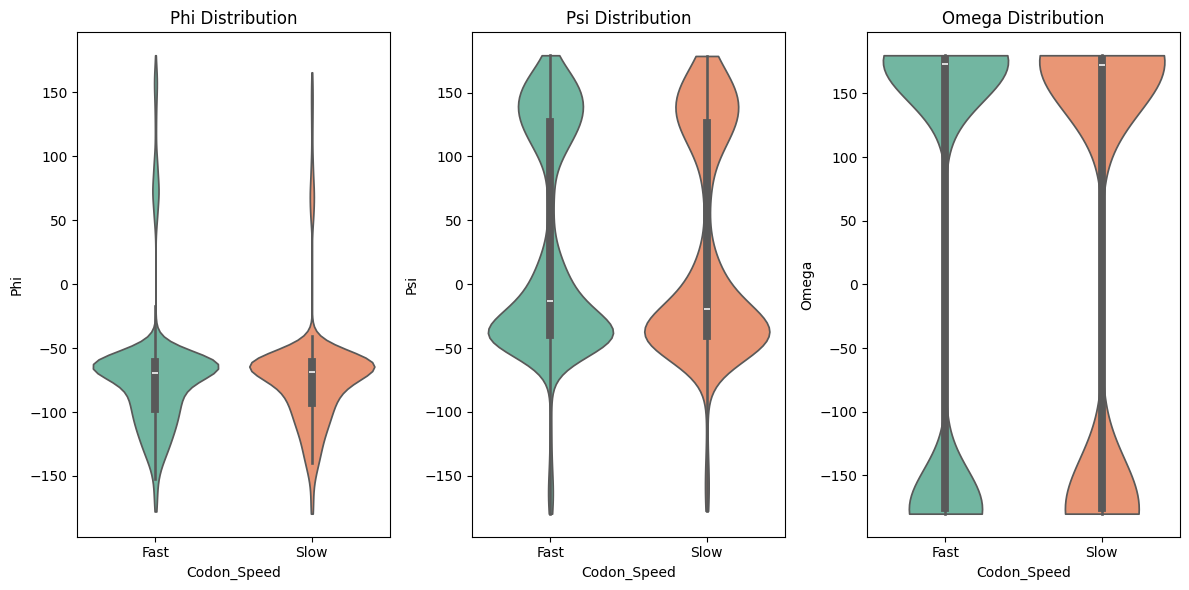

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

# Load your dataset
df = pd.read_csv("new_codon_torsions_freq.csv")


# Drop rows with missing torsion angles
df_clean = df.dropna(subset=["Phi", "Psi", "Omega", "Relative_Frequency"])

# Define slow codons (Relative_Freq < 0.5)
df_clean["Codon_Speed"] = df_clean["Relative_Frequency"].apply(lambda x: "Slow" if x < 0.3 else "Fast")

# ---- Statistical Tests ----
results = {}
for angle in ["Phi", "Psi", "Omega"]:
    slow = df_clean[df_clean["Codon_Speed"] == "Slow"][angle]
    fast = df_clean[df_clean["Codon_Speed"] == "Fast"][angle]
    
    # Independent t-test
    t_stat, p_ttest = ttest_ind(slow, fast, nan_policy="omit")
    
    # Mann-Whitney U test (non-parametric)
    u_stat, p_mw = mannwhitneyu(slow, fast, alternative="two-sided")
    
    results[angle] = {
        "t-test p-value": p_ttest,
        "Mann-Whitney p-value": p_mw,
        "mean_slow": slow.mean(),
        "mean_fast": fast.mean()
    }

print("Comparison Results:")
for k,v in results.items():
    print(f"{k}: {v}")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
for i, angle in enumerate(["Phi", "Psi", "Omega"], 1):
    plt.subplot(1, 3, i)
    sns.violinplot(x="Codon_Speed", y=angle, data=df_clean, palette="Set2", cut=0)
    plt.title(f"{angle} Distribution")
plt.tight_layout()
plt.show()
